## Starting with 10 features

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import accuracy_score


In [272]:
df = pd.read_csv("../data/ESS10/ESS10.csv")

/tmp/ipykernel_10038/53951641.py:1: DtypeWarning: Columns (166,172,174,607,608) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/ESS10/ESS10.csv")


| feature | min     | max       | *          |
| ------- | ------- | --------- | ---------- |
| sclmeet | 1       | 7         | 77, 88, 99 |
| inprdsc | 0       | 6         | 77, 88, 99 |
| sclact  | 1       | 5         | 7, 8, 9    |
| health  | 1       | 5         | 7, 8, 9    |
| rlgdgr  | 0       | 10        | 77, 88, 99 |
| dscrgrp | 1(yes)  | 2(no)     | 7, 8, 9    |
| ctzcntr | 1(yes)  | 2(no)     | 7, 8, 9    |
| brncntr | 1(yes)  | 2(no)     | 7, 8, 9    |
| gndr    | 1(male) | 0(female) | 9          |



In [2]:
def feature_scale_map(df, feature):
    map_dict = {}

    all_vals = np.sort(df[feature].unique())

    if np.any(all_vals[1:] - all_vals[0:-1] > 1):
        min_ind = np.where(all_vals[1:] - all_vals[0:-1] > 1)[0][0]
        vals = all_vals[:min_ind].copy()
        min_val = vals.min()
        if min_val == 1:
            vals = vals - 1
        for i, val in enumerate(all_vals[:-1]):
            map_dict[val] = i
        map_dict[all_vals[-1]] = -1
        df[feature] = df[feature].replace(map_dict)
    else:
        for i, val in enumerate(all_vals):
            map_dict[val] = i
        df[feature] = df[feature].replace(map_dict)

In [274]:
base_df = df[
    ['cntry', 'gndr','sclmeet',
     'inprdsc','sclact','health',
     'rlgdgr','dscrgrp','ctzcntr',
     'brncntr', 'happy']
]


mask = base_df["happy"].isin([77, 88, 99])
base_df = base_df[~mask].reset_index(drop=True)

for col in base_df.columns[1:]:
    feature_scale_map(base_df, col)


In [282]:
base_df['sclmeet'].unique()

array([ 4,  3,  5,  1,  6,  2,  0,  8,  7, -1])

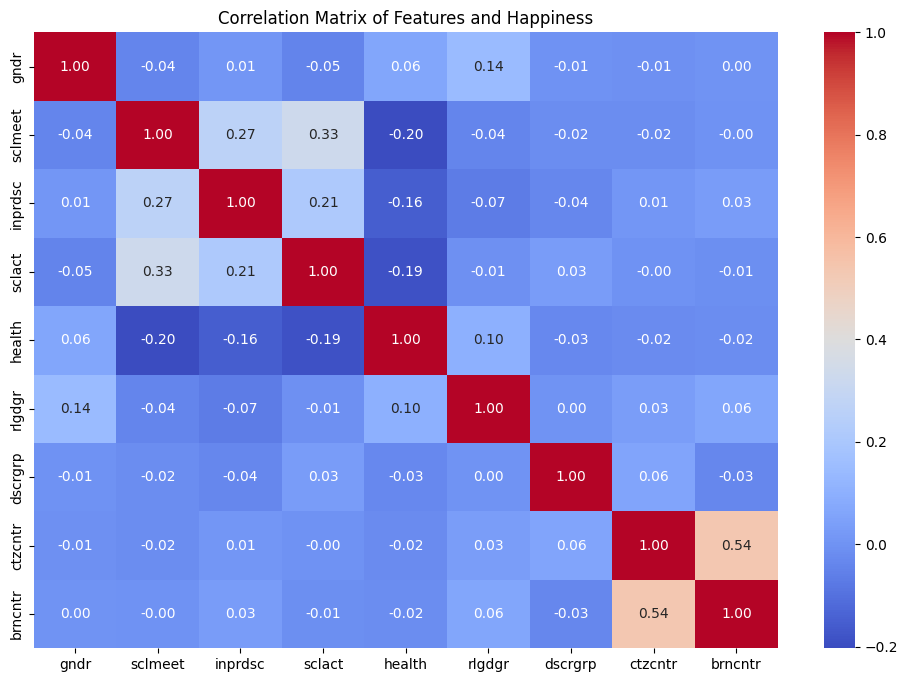

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
cor_mat = base_df.drop(['happy','cntry'], axis=1).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(cor_mat, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Features and Happiness')
plt.show()

In [5]:
# minmax = MinMaxScaler()
# base_df_scaled = minmax.fit_transform(base_df[base_df.columns[1:-1]])
# base_df_scaled = pd.DataFrame(base_df_scaled, columns=base_df.columns[1:-1])

In [20]:
encoder = OneHotEncoder(drop='if_binary')
encoded_df = encoder.fit_transform(base_df.drop('happy', axis=1)).toarray()
df_encoded = pd.concat(
    [pd.DataFrame(encoded_df, columns=encoder.get_feature_names_out())
    ],
    axis=1)
# # df_encoded = df_encoded.astype(float)
df_encoded.columns

Index(['cntry_BE', 'cntry_BG', 'cntry_CH', 'cntry_CZ', 'cntry_EE', 'cntry_FI',
       'cntry_FR', 'cntry_GB', 'cntry_GR', 'cntry_HR', 'cntry_HU', 'cntry_IE',
       'cntry_IS', 'cntry_IT', 'cntry_LT', 'cntry_ME', 'cntry_MK', 'cntry_NL',
       'cntry_NO', 'cntry_PT', 'cntry_SI', 'cntry_SK', 'gndr_1', 'sclmeet_-1',
       'sclmeet_0', 'sclmeet_1', 'sclmeet_2', 'sclmeet_3', 'sclmeet_4',
       'sclmeet_5', 'sclmeet_6', 'sclmeet_7', 'sclmeet_8', 'inprdsc_-1',
       'inprdsc_0', 'inprdsc_1', 'inprdsc_2', 'inprdsc_3', 'inprdsc_4',
       'inprdsc_5', 'inprdsc_6', 'inprdsc_7', 'inprdsc_8', 'sclact_-1',
       'sclact_0', 'sclact_1', 'sclact_2', 'sclact_3', 'sclact_4', 'sclact_5',
       'sclact_6', 'health_-1', 'health_0', 'health_1', 'health_2', 'health_3',
       'health_4', 'health_5', 'health_6', 'rlgdgr_-1', 'rlgdgr_0', 'rlgdgr_1',
       'rlgdgr_2', 'rlgdgr_3', 'rlgdgr_4', 'rlgdgr_5', 'rlgdgr_6', 'rlgdgr_7',
       'rlgdgr_8', 'rlgdgr_9', 'rlgdgr_10', 'rlgdgr_11', 'rlgdgr_12',
       

In [ ]:
# encoder = OneHotEncoder()
# encoded_countries = encoder.fit_transform(base_df[['cntry']]).toarray()
# df_encoded = pd.concat(
#     [pd.DataFrame(encoded_countries, columns=encoder.get_feature_names_out()),
#      base_df_scaled,
#      base_df["happy"]
#     ],
#     axis=1)
# df_encoded = df_encoded.astype(float)
# df_encoded.head()

In [21]:
X = df_encoded.copy()
y = base_df["happy"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.2
)

In [ ]:
# X = df_encoded.drop("happy", axis=1).copy()
# y = df_encoded["happy"].copy()

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, random_state=0, test_size=0.2
# )

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform 5-fold cross-validation and print the accuracy scores
cv_scores = cross_val_score(rf, X, y, cv=5)

print(f"CV Scores: {cv_scores}")
print(f"Average CV Score: {cv_scores.mean():.2f}")

CV Scores: [0.19960027 0.20175906 0.18083689 0.16044776 0.25413113]
Average CV Score: 0.20


In [26]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
dt.fit(X_train, y_train)

# Make predictions on the test data
predictions = dt.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 21.37%


In [24]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the test data
predictions = rf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 25.42%


In [22]:
clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(set(y)),
    eval_metric='mlogloss',
)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 29.70%


# ADD another 10 features

| feature | min     | max       | *          |
| ------- | ------- | --------- | ---------- |
| imwbcnt | 0       | 10        | 77, 88, 99 |
| imprich | 1       | 6         | 7, 8, 9    |
| ipeqopt | 1       | 6         | 7, 8, 9    |
| health  | 1       | 5         | 7, 8, 9    |
| rlgdgr  | 0       | 10        | 77, 88, 99 |
| dscrgrp | 1(yes)  | 2(no)     | 7, 8, 9    |
| ctzcntr | 1(yes)  | 2(no)     | 7, 8, 9    |
| brncntr | 1(yes)  | 2(no)     | 7, 8, 9    |
| gndr    | 1(male) | 0(female) | 9          |



In [38]:
np.sort(df['ipeqopt'].unique())

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

# whole dataset

In [24]:
data = pd.read_csv('/home/mehrshad/code/arthurcornelio88/how-happy-in-europe/data/20240319_ESS10_manually-filtered_arthurcornelio88.csv')
data = data.drop("Unnamed: 0", axis=1)
data= data.drop(['livecnta','gndr13','yrbrn6','yrbrn7','yrbrn8','yrbrn9','yrbrn10','yrbrn11','yrbrn12','yrbrn13','rshipa8','rshipa9','rshipa10','rshipa11','rshipa12', 'rshipa13',
                    'edulvlb','pdjobyr','isco08','edulvlpb','isco08p','wkhtotp','edulvlfb','edulvlfb','edulvlmb','anctry1','anctry2'], axis=1)
mask = data["happy"].isin([77, 88, 99])
data = data[~mask].reset_index(drop=True)
data.head()

/tmp/ipykernel_22803/3662282358.py:1: DtypeWarning: Columns (82,88,90) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/home/mehrshad/code/arthurcornelio88/how-happy-in-europe/data/20240319_ESS10_manually-filtered_arthurcornelio88.csv')


idno cntry  netusoft  ppltrst  pplfair  pplhlp  polintr  psppsgva  \
0  10038    BE         5        6        7       4        2         2   
1  10053    BE         5        3        4       3        4         1   
2  10055    BE         5        6        8       5        2         3   
3  10062    BE         5        7        5       5        4         2   
4  10064    BE         5        3        8       8        1         2   

   actrolga  psppipla  ...  vdtpitre  vdtpscre  vdtpaure  vdtpvire  vdtpoire  \
0         1         3  ...         0         0         0         0         0   
1         4         2  ...         0         0         0         0         0   
2         3         3  ...         0         0         0         0         0   
3         1         2  ...         0         0         0         0         0   
4         2         2  ...         0         0         0         0         0   

   vdtpntre  vdtpapre  vdtprere  vdtpdkre  vdtpnare  
0         0         1         0         0         0  
1         1         0         0         0         0  
2         0         1         0         0         0  
3         0         1         0         0         0  
4         0         1         0         0         0  

[5 rows x 386 columns]

In [25]:
X = data.drop('happy',axis=1)
y = data['happy']


In [26]:
X_numerical = X.select_dtypes(exclude='object')

In [27]:
for col in X_numerical.columns:
    feature_scale_map(X_numerical, col)

In [28]:
minmax = MinMaxScaler()
base_df_scaled = minmax.fit_transform(X_numerical)
base_df_scaled = pd.DataFrame(base_df_scaled, columns=X_numerical.columns)

In [29]:
encoder = OneHotEncoder(drop='if_binary')
encoded_countries = encoder.fit_transform(X[['cntry','ctzcntr','brncntr','gndr', 'dscrgrp']]).toarray()
df_encoded = pd.concat(
    [pd.DataFrame(encoded_countries, columns=encoder.get_feature_names_out()),
     X_numerical
    ],
    axis=1)
df_encoded = df_encoded.astype(float)
df_encoded.head()

cntry_BE  cntry_BG  cntry_CH  cntry_CZ  cntry_EE  cntry_FI  cntry_FR  \
0       1.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       1.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       1.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       1.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       1.0       0.0       0.0       0.0       0.0       0.0       0.0   

   cntry_GB  cntry_GR  cntry_HR  ...  vdtpitre  vdtpscre  vdtpaure  vdtpvire  \
0       0.0       0.0       0.0  ...       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0  ...       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0  ...       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0  ...       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0  ...       0.0       0.0       0.0       0.0   

   vdtpoire  vdtpntre  vdtpapre  vdtprere  vdtpdkre  vdtpnare  
0       0.0       0.0       1.0       0.0       0.0       0.0  
1       0.0       1.0       0.0       0.0       0.0       0.0  
2       0.0       0.0       1.0       0.0       0.0       0.0  
3       0.0       0.0       1.0       0.0       0.0       0.0  
4       0.0       0.0       1.0       0.0       0.0       0.0  

[5 rows x 416 columns]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    df_encoded, y, random_state=0, test_size=0.2
)

In [31]:
clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(set(y)),
    eval_metric='mlogloss',
)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 33.98%


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Assuming 'data' is your initial DataFrame and 'X' and 'y' are defined as before.

# Separate the features and the target variable
X = data.drop('happy', axis=1)
y = data['happy']

# Select numerical and categorical columns
numerical_cols = X.select_dtypes(exclude='object').columns
categorical_cols = X[['cntry','ctzcntr','brncntr','gndr', 'dscrgrp']].columns

# Create the preprocessing steps for both types of features
numerical_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(drop='if_binary')

# Use ColumnTransformer to apply the transformations to the correct columns in the DataFrame
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create the pipeline that includes the preprocessing and the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective='multi:softprob',
                                 num_class=len(set(y)),
                                 eval_metric='mlogloss'))
])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict using the pipeline
y_pred = pipeline.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 34.38%


In [279]:
import numpy as np
from sklearn.inspection import permutation_importance

permutation_score = permutation_importance(clf, X_train, y_train, n_repeats=100) # Perform Permutation

importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'feature_importance': permutation_score.importances_mean
})

importance_df.columns=['feature','feature importance'] # Change column names

importance_df.sort_values(by="feature importance", ascending = False, inplace=True, ignore_index=True) # Order by importance

KeyboardInterrupt: 

In [270]:
y_pred

array([8, 9, 8, ..., 8, 3, 8])

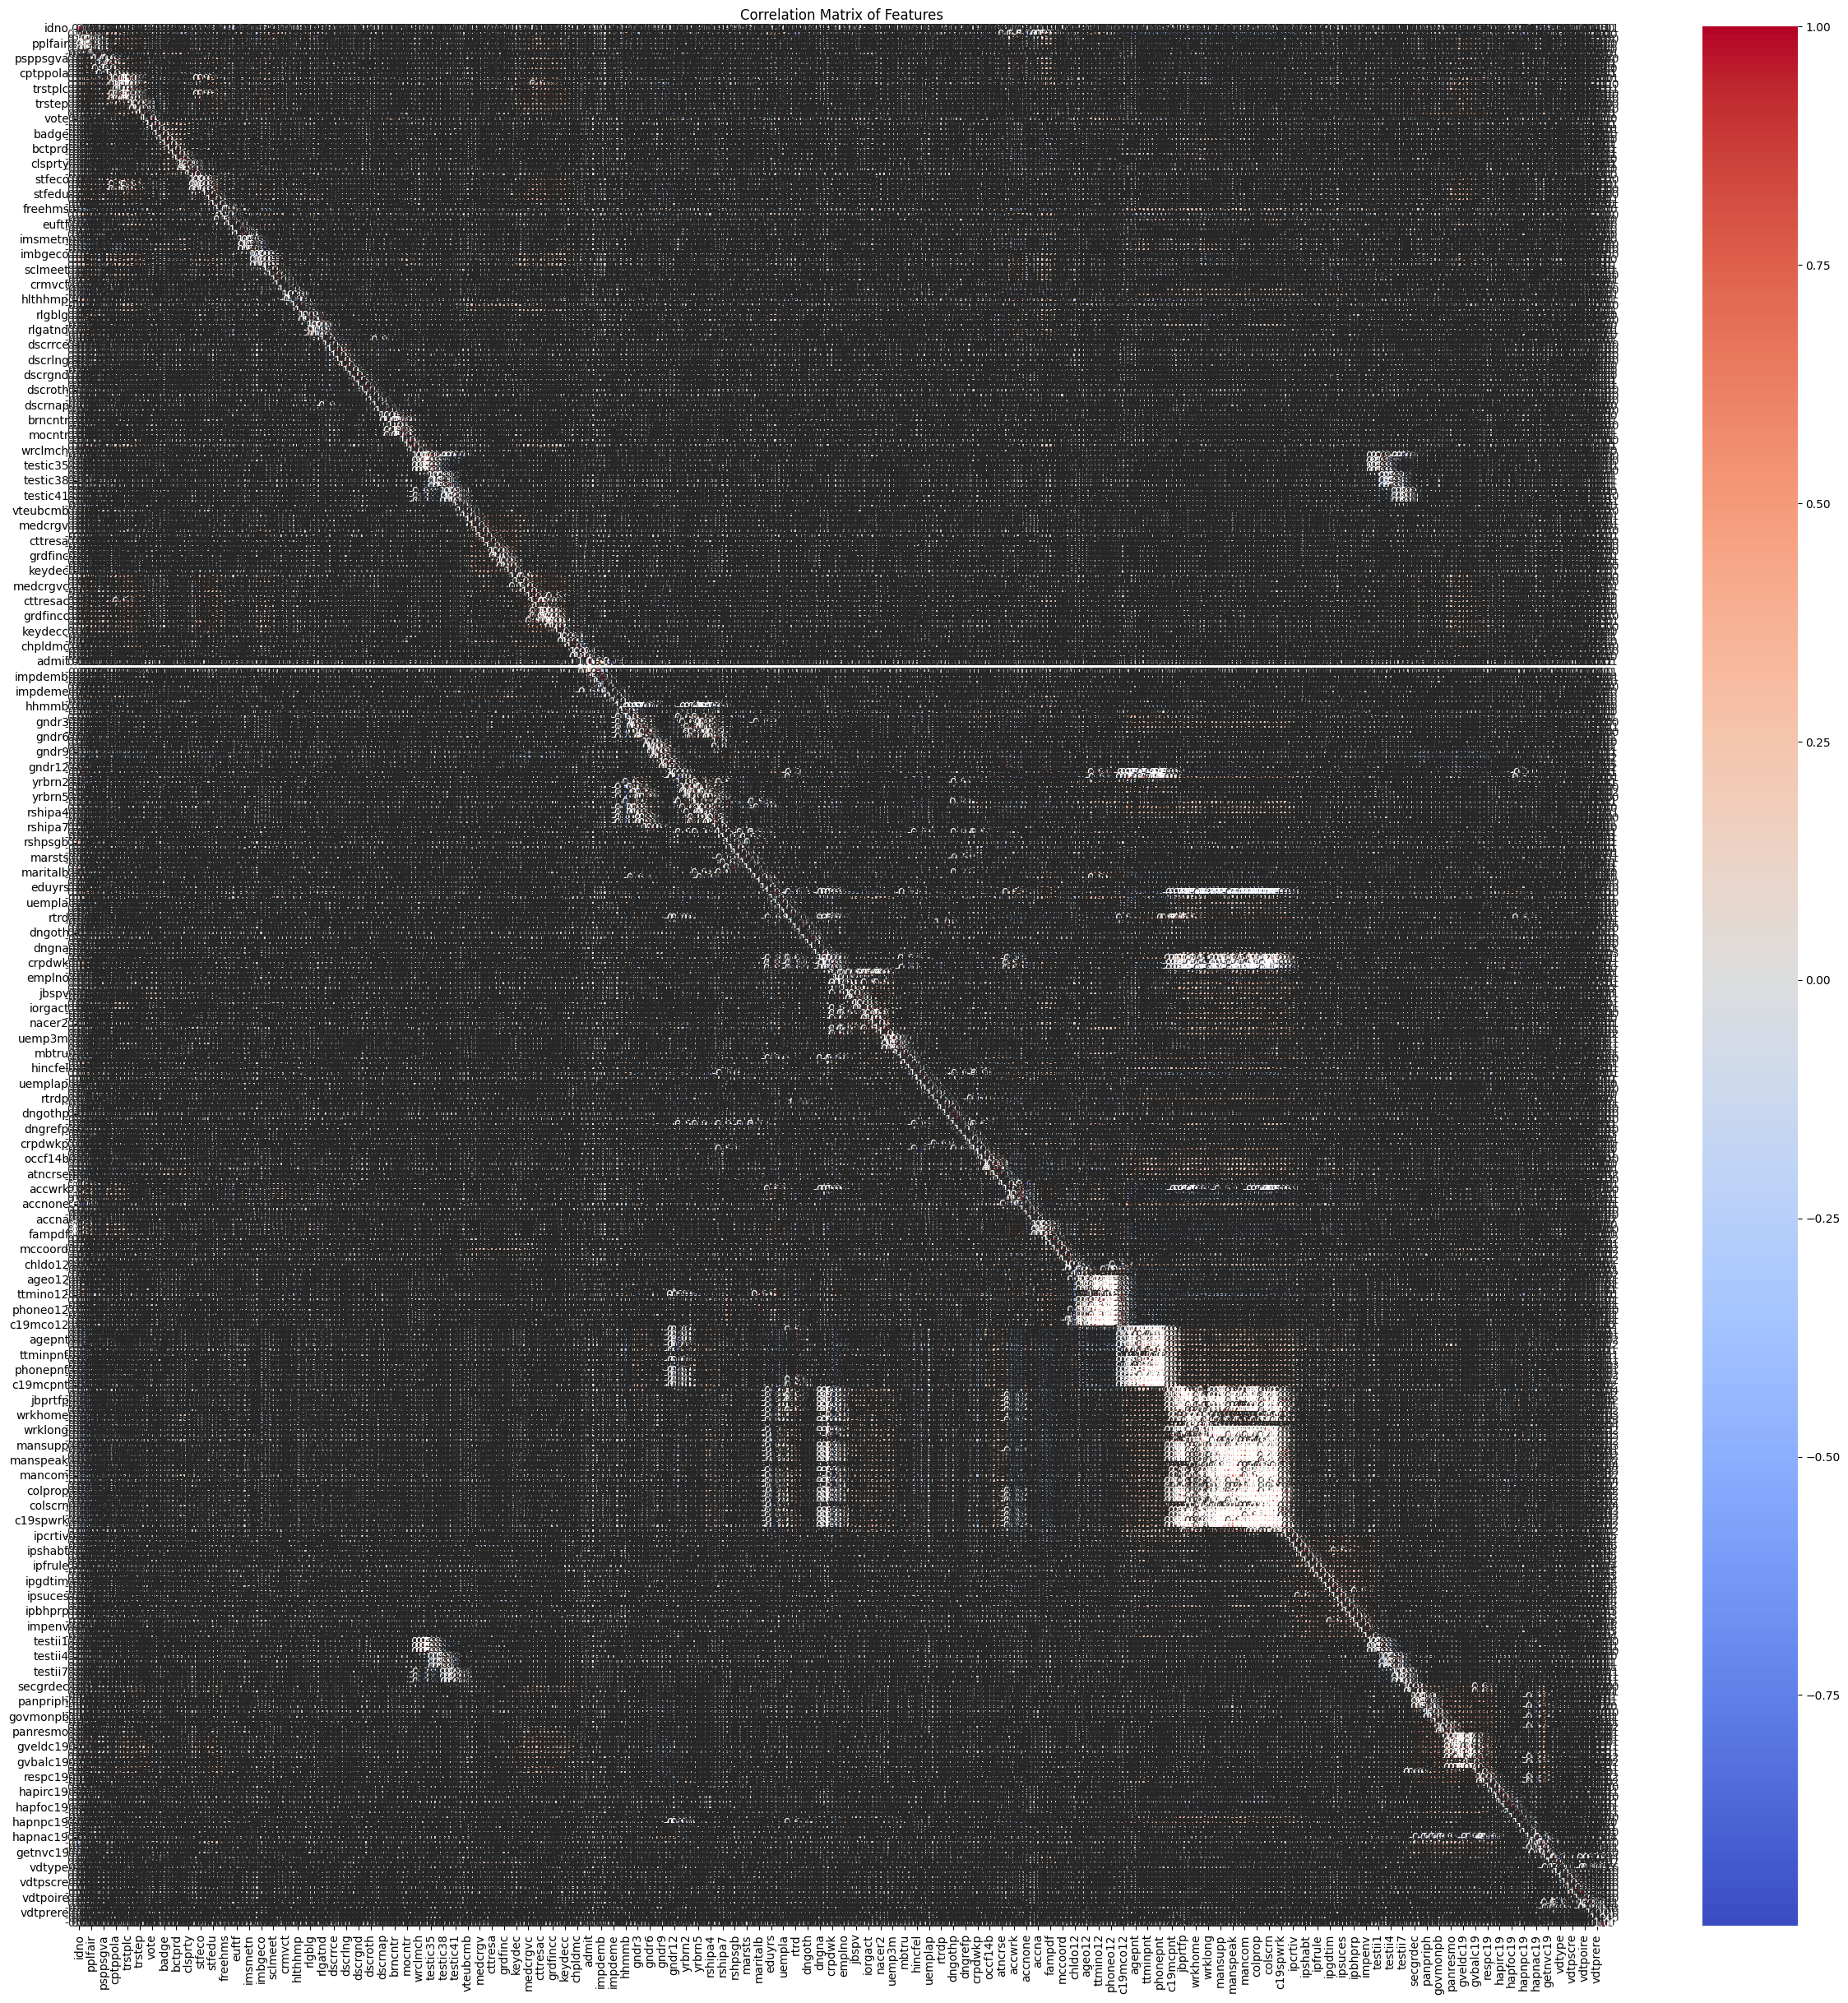

In [269]:
# cor_mat = X_reduced.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(cor_mat, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Features')
plt.show()

In [255]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

In [50]:
import numpy as np
from sklearn.inspection import permutation_importance

model = LinearRegression().fit(X_imputed, y) # Fit model

permutation_score = permutation_importance(model, X_imputed, y, n_repeats=100) # Perform Permutation

importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score.importances_mean)).T) # Unstack results

importance_df.columns=['feature','feature importance'] # Change column names

importance_df.sort_values(by="feature importance", ascending = False, inplace=True, ignore_index=True) # Order by importance
importance_df

feature feature importance
0       gndr9            0.22997
1       gndr8           0.207119
2     rshipa9           0.129216
3     rshipa8           0.125921
4      gndr11           0.117681
..        ...                ...
400    gndr12                0.0
401    gndr13               -0.0
402  rshipa13               -0.0
403  hapljc19               -0.0
404   iprspot               -0.0

[405 rows x 2 columns]

In [70]:
importance_df.head(50)

feature feature importance
0      gndr9            0.22997
1      gndr8           0.207119
2    rshipa9           0.129216
3    rshipa8           0.125921
4     gndr11           0.117681
5   rshipa11           0.089245
6    dngnapp           0.053349
7     compnt           0.027687
8    rshpsts           0.018753
9     showcv           0.014361
10  phoneo12            0.01259
11     gndr7           0.010966
12    yrbrn9           0.010116
13   sclmeet           0.010045
14   rshipa7           0.009827
15    health           0.009673
16   testii6           0.008741
17   chpldmi           0.007805
18  speako12           0.007482
19    pdwrkp           0.006967
20   testii7           0.006927
21    mancom           0.006905
22   inprdsc           0.006727
23    chpldm           0.006649
24    yrbrn5           0.006423
25   atchctr           0.006355
26  testic42           0.006346
27     hhmmb           0.006029
28    como12           0.005944
29    yrbrn8           0.005623
30  closepnt           0.005524
31     rtrdp             0.0054
32  teamfeel           0.005189
33   trstsci           0.005081
34  govmonpb           0.004665
35   hincfel           0.004553
36  testic41           0.004307
37   hhlio12           0.004173
38    livpnt           0.004147
39  c19sppnt           0.003989
40    hswrkp           0.003989
41   scrno12           0.003907
42      agea           0.003803
43    manhlp           0.003743
44  panmonpb            0.00374
45     yrbrn           0.003731
46   trstplc           0.003574
47  testic35           0.003553
48   colscrn           0.003414
49  vdtpapre           0.003386